In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # THÊM DÒNG NÀY
import random

# Set seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

MONET_JPG_PATH = '/kaggle/input/gan-getting-started/monet_jpg/'
PHOTO_JPG_PATH = '/kaggle/input/gan-getting-started/photo_jpg/'

monet_files = tf.io.gfile.glob(os.path.join(MONET_JPG_PATH, '*.jpg'))
photo_files = tf.io.gfile.glob(os.path.join(PHOTO_JPG_PATH, '*.jpg'))

print(f"Number of Monet paintings: {len(monet_files)}")
print(f"Number of Photos: {len(photo_files)}")

IMAGE_SIZE = [256, 256]
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0
    return image

def data_augmentation(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.resize(image, [286, 286])
    image = tf.image.random_crop(image, size=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    image = tf.clip_by_value(image, -1, 1)
    return image

monet_ds = tf.data.Dataset.from_tensor_slices(monet_files).map(decode_image, num_parallel_calls=AUTOTUNE)
photo_ds = tf.data.Dataset.from_tensor_slices(photo_files).map(decode_image, num_parallel_calls=AUTOTUNE)
monet_ds = monet_ds.map(data_augmentation, num_parallel_calls=AUTOTUNE)
photo_ds = photo_ds.map(data_augmentation, num_parallel_calls=AUTOTUNE)
BUFFER_SIZE = 1024
monet_ds = monet_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
photo_ds = photo_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)

2025-05-31 18:19:29.609508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748715569.855996      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748715569.931071      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of Monet paintings: 300
Number of Photos: 7038


2025-05-31 18:19:45.125474: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


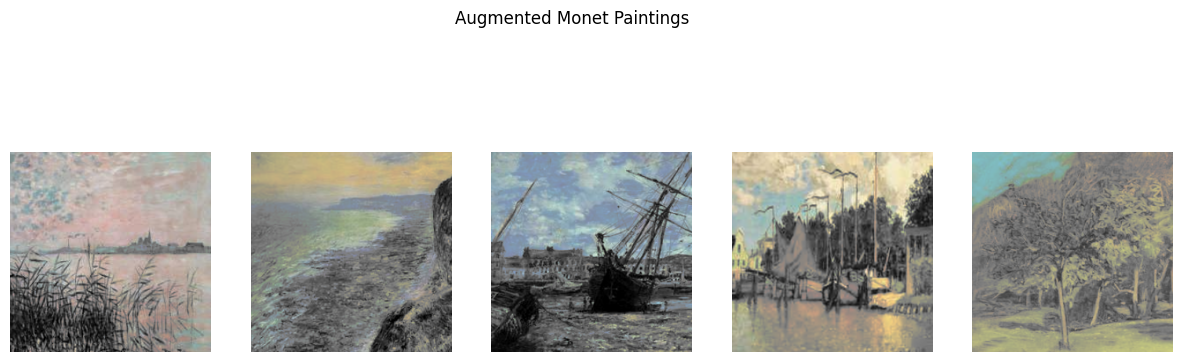

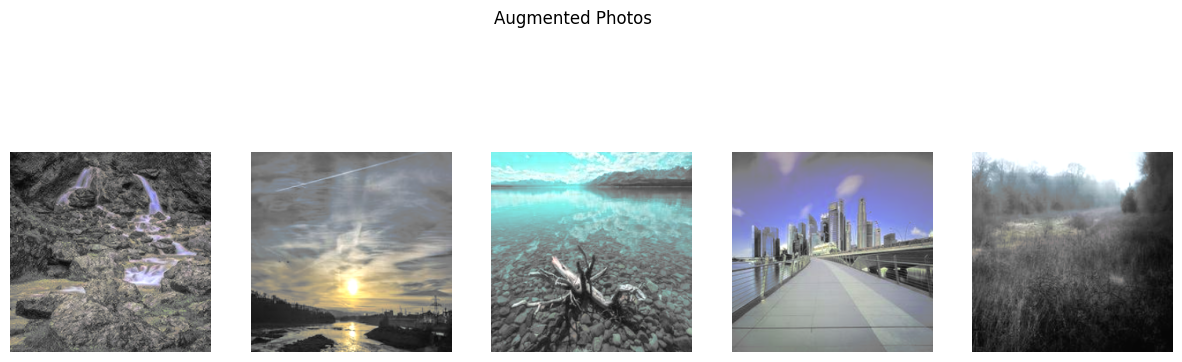

In [3]:
def visualize_samples(dataset, num=5, title="Samples"):
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(dataset.take(num)):
        plt.subplot(1, num, i+1)
        plt.imshow((img[0].numpy() + 1) / 2)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

visualize_samples(monet_ds, title="Augmented Monet Paintings")
visualize_samples(photo_ds, title="Augmented Photos")

In [4]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU(0.2))
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def residual_block(input_tensor, filters, size=3):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = layers.Conv2D(filters, size, padding='same', kernel_initializer=initializer, use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, size, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    return layers.add([input_tensor, x])

def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])
    x = layers.Conv2D(64, 7, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = downsample(128, 3)(x)
    x = downsample(256, 3)(x)
    for _ in range(9):
        x = residual_block(x, 256)
    x = upsample(128, 3)(x)
    x = upsample(64, 3)(x)
    x = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)
    return keras.Model(inputs=inputs, outputs=x)

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3])
    x = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer)(inp)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(512, 4, strides=1, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(x)
    return keras.Model(inputs=inp, outputs=x)

# Create models
generator_g = build_generator()  # Photo -> Monet
generator_f = build_generator()  # Monet -> Photo
discriminator_x = build_discriminator()  # Monet
discriminator_y = build_discriminator()  # Photo

def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image, lambda_cycle=10):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

initial_lr = 5e-4
generator_g_optimizer = tf.keras.optimizers.Adam(initial_lr, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(initial_lr, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(initial_lr, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(initial_lr, beta_1=0.5)

In [5]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_x = generator_g(real_y, training=True)
        fake_y = generator_f(real_x, training=True)
        cycled_x = generator_f(fake_x, training=True)
        cycled_y = generator_g(fake_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        gen_g_loss = generator_loss(disc_fake_x)
        gen_f_loss = generator_loss(disc_fake_y)
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        
        total_gen_g_loss = gen_g_loss + total_cycle_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))
    
    return {
        'gen_g_loss': total_gen_g_loss,
        'gen_f_loss': total_gen_f_loss,
        'disc_x_loss': disc_x_loss,
        'disc_y_loss': disc_y_loss
    }

=== GPU Status ===
GPU Available: []
GPU Support: True
Current device: 
Starting serious training for better results...
Note: Training 100 steps để có kết quả tốt. Hãy kiên nhẫn...
Step  10/100 | Time:  21.0s | Gen_G: 10.473 | Gen_F: 10.646 | Best:  9.118 | ETA: 40.6min
Step  20/100 | Time:  20.8s | Gen_G:  7.577 | Gen_F:  7.682 | Best:  7.630 | ETA: 31.6min

=== Showing results at step 20 ===


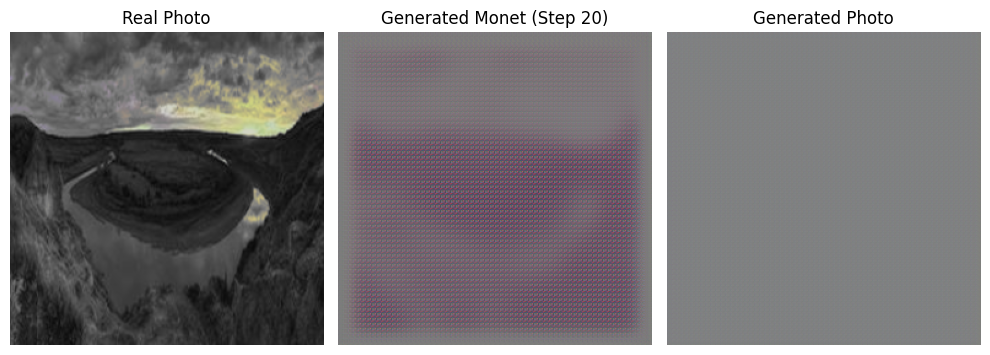

🔶 Making progress. Keep training...
Step  30/100 | Time:  20.6s | Gen_G:  9.257 | Gen_F:  9.251 | Best:  6.234 | ETA: 26.5min
Step  40/100 | Time:  20.1s | Gen_G:  9.107 | Gen_F:  8.857 | Best:  6.234 | ETA: 22.1min

=== Showing results at step 40 ===


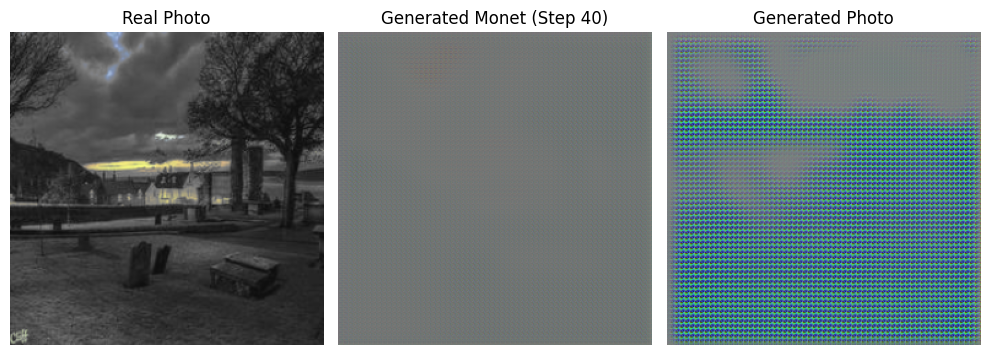

🔴 Still learning basic patterns. Need more steps.
Step  50/100 | Time:  20.3s | Gen_G:  6.882 | Gen_F:  7.039 | Best:  6.234 | ETA: 18.2min
Step  60/100 | Time:  20.7s | Gen_G:  7.352 | Gen_F:  7.184 | Best:  6.234 | ETA: 14.4min

=== Showing results at step 60 ===


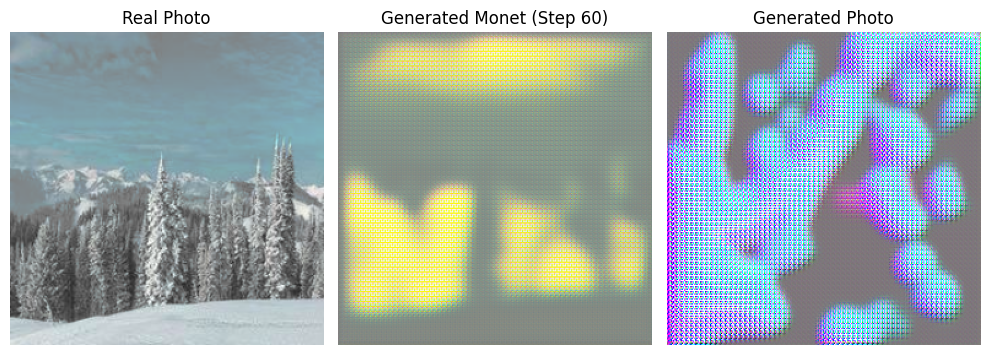

🔶 Making progress. Keep training...
Step  70/100 | Time:  20.3s | Gen_G: 10.387 | Gen_F: 10.483 | Best:  6.234 | ETA: 10.8min
Step  80/100 | Time:  20.7s | Gen_G: 10.034 | Gen_F: 10.236 | Best:  6.234 | ETA: 7.1min

=== Showing results at step 80 ===


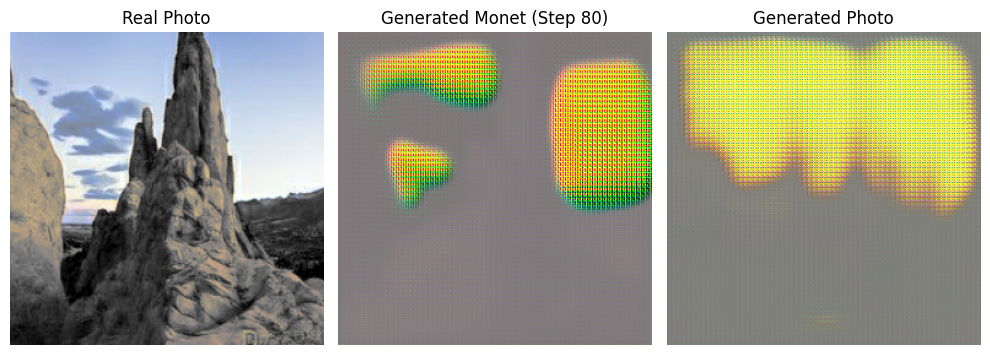

🔴 Still learning basic patterns. Need more steps.
Step  90/100 | Time:  19.8s | Gen_G:  8.575 | Gen_F:  8.732 | Best:  6.234 | ETA: 3.5min
Step 100/100 | Time:  19.5s | Gen_G:  7.947 | Gen_F:  8.441 | Best:  6.234 | ETA: 0.0min

=== Showing results at step 100 ===


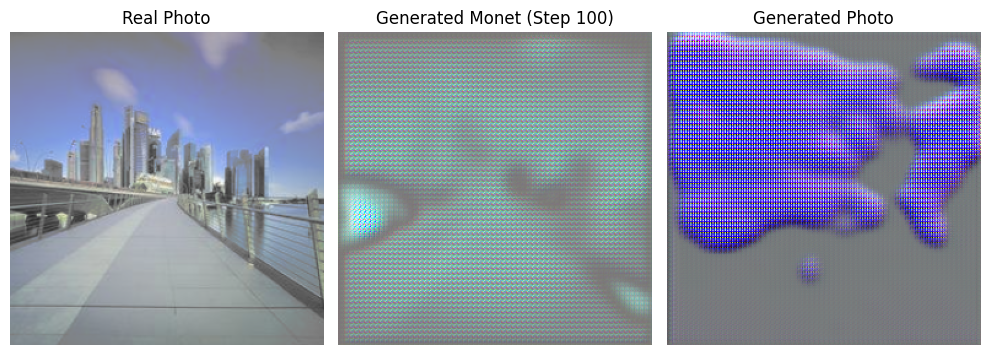


🎉 Training completed in 2117.3s (35.3 minutes)!

Testing on multiple photos...


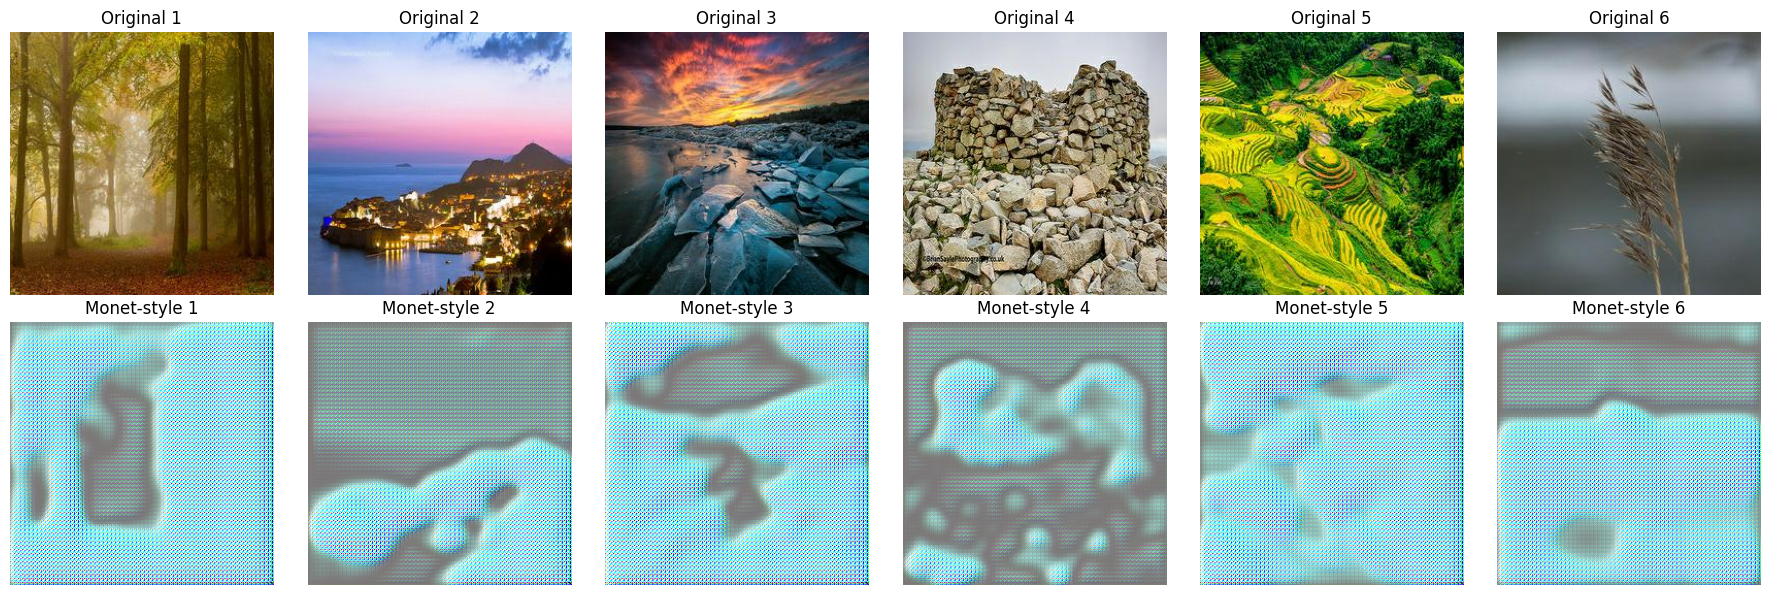


=== Training Summary ===
Total steps: 100
Total time: 2117.3s (35.3 minutes)
Average time per step: 21.2s
Best generator loss achieved: 6.234
🔶 Fair. Some Monet characteristics visible.


In [6]:
print("=== GPU Status ===")
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("GPU Support:", tf.test.is_built_with_cuda())
print("Current device:", tf.test.gpu_device_name())
print("==================")

print("Starting serious training for better results...")
TOTAL_STEPS = 100
SHOW_EVERY = 20 
PRINT_EVERY = 10

import time
start_time = time.time()

# Để track loss tốt nhất
best_gen_loss = float('inf')
no_improve_count = 0

print("Note: Training 100 steps. Be patient...")

for step in range(TOTAL_STEPS):
    step_start = time.time()
    
    # Lấy batch
    batch_monet = next(iter(monet_ds.take(1)))
    batch_photos = next(iter(photo_ds.take(1)))
    
    # Chỉ lấy 1 ảnh từ batch
    batch_monet = batch_monet[:1]  
    batch_photos = batch_photos[:1]
    
    losses = train_step(batch_monet, batch_photos)
    
    step_time = time.time() - step_start
    
    # Track progress
    current_gen_loss = (losses['gen_g_loss'] + losses['gen_f_loss']) / 2
    if current_gen_loss < best_gen_loss:
        best_gen_loss = current_gen_loss
        no_improve_count = 0
    else:
        no_improve_count += 1
    
    # Print progress PRINT_EVERY steps
    if (step + 1) % PRINT_EVERY == 0:
        elapsed = time.time() - start_time
        eta = (elapsed / (step + 1)) * (TOTAL_STEPS - step - 1)
        
        print(f"Step {step+1:3d}/{TOTAL_STEPS} | "
              f"Time: {step_time:5.1f}s | "
              f"Gen_G: {losses['gen_g_loss']:6.3f} | "
              f"Gen_F: {losses['gen_f_loss']:6.3f} | "
              f"Best: {best_gen_loss:6.3f} | "
              f"ETA: {eta/60:.1f}min")
    
    # Show image SHOW_EVERY steps or last step
    if (step + 1) % SHOW_EVERY == 0 or (step + 1) == TOTAL_STEPS:
        print(f"\n=== Showing results at step {step+1} ===")
        
        fake_monet = generator_g(batch_photos, training=False)
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow((batch_photos[0] + 1) / 2)
        plt.title("Real Photo")
        plt.axis('off')
        
        plt.subplot(1, 3, 2) 
        plt.imshow((fake_monet[0] + 1) / 2)
        plt.title(f"Generated Monet (Step {step+1})")
        plt.axis('off')
        
        # Thêm cycle consistency check
        fake_photo = generator_f(batch_monet, training=False)
        plt.subplot(1, 3, 3)
        plt.imshow((fake_photo[0] + 1) / 2)
        plt.title("Generated Photo")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Progress report
        if (step + 1) < TOTAL_STEPS:
            if current_gen_loss < 5:
                print("✅ Good progress! Images should be getting better.")
            elif current_gen_loss < 8:
                print("🔶 Making progress. Keep training...")
            else:
                print("🔴 Still learning basic patterns. Need more steps.")

total_time = time.time() - start_time
print(f"\n🎉 Training completed in {total_time:.1f}s ({total_time/60:.1f} minutes)!")

# Test mutiple image to evaluate result
print("\nTesting on multiple photos...")
test_photos = glob(os.path.join(PHOTO_JPG_PATH, '*.jpg'))[:6]  # Test với 6 ảnh

plt.figure(figsize=(18, 6))
for i, photo_path in enumerate(test_photos):
    # Load and image processing
    img = load_img(photo_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_normalized = (img_array / 127.5) - 1.0
    img_batch = np.expand_dims(img_normalized, 0)
    
    # Generate Monet-style
    generated = generator_g(img_batch, training=False)
    generated_img = (generated[0] + 1) / 2
    
    # Display result
    plt.subplot(2, 6, i+1)
    plt.imshow(img)
    plt.title(f"Original {i+1}")
    plt.axis('off')
    
    plt.subplot(2, 6, i+7)
    plt.imshow(generated_img)
    plt.title(f"Monet-style {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Training summary to evaluate
print("\n=== Training Summary ===")
print(f"Total steps: {TOTAL_STEPS}")
print(f"Total time: {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"Average time per step: {total_time/TOTAL_STEPS:.1f}s")
print(f"Best generator loss achieved: {best_gen_loss:.3f}")

# Evaluate result
if best_gen_loss < 2:
    print("🎯 Excellent! Model learned Monet style very well.")
elif best_gen_loss < 4:
    print("👍 Good! Model learned basic Monet patterns.")
elif best_gen_loss < 7:
    print("🔶 Fair. Some Monet characteristics visible.")
else:
    print("🔴 Poor. Need more training steps (200-500) for good results.")